# Exploring when you are using Spark

- We will need to use matplotlib or seaborn to visualize
- This means that the data we want to visualize needs to be an a pandas dataframe
- This could run into issues with the size of your data, which is usually large...the very reason you were driven to use spark. So, what's the solution? 
- Before anything begin by taking a look at your data and removing any unnecessary columns or observations. 

Options include:

1. We could explore the full spark dataframe through summary statistics and aggregate tables 
2. We could aggregate our data in such a way where we are visualizing the aggregations, some summaries, as opposed to indidividual data points. So after aggregation, we convert the aggregated dataframe to the pandas dataframe to then visualize.   
4. Attempt to visualize all observations
5. Sample
    > A. use a basic random sample  
    > B. stratify your sample  
    > C. break your data into multiple dataframes with observations together that you would want to compare. E.g. create a dataframe of all open, all closed, all tickets from a certain department, etc.   

In [35]:
import warnings

warnings.filterwarnings("ignore")

import pyspark.sql
from pyspark.sql.functions import *

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from wrangle import wrangle_311

spark = pyspark.sql.SparkSession.builder.getOrCreate()

df = wrangle_311(spark)
print("\ndf shape: (%d, %d)\n" % (df.count(), len(df.columns)))
df.show(1, vertical=True)

[wrangle.py] reading case.csv
[wrangle.py] handling data types
[wrangle.py] parsing dates
[wrangle.py] adding features
[wrangle.py] joining departments

df shape: (841704, 20)

-RECORD 0------------------------------------
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 case_due_date        | 2020-09-26 00:42:00  
 case_late            | false                
 num_days_late        | -998.5087616000001   
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 source_id            | svcCRMLS             
 request_address      | 2315  EL PASO ST,... 
 council_district     | 005                  
 num_weeks_late       | -142.6441088         
 zipcode              | 78207                
 case_age             | 219                  
 days_to_closed       | 0                

## Reduce dataframe size

Remove columns I will not be using in exploration

In [36]:
# only 33 are not subject...not enough data for much. So, I'll remove that column. 
df.groupBy('dept_subject_to_SLA').count().show()

+-------------------+------+
|dept_subject_to_SLA| count|
+-------------------+------+
|               true|841671|
|              false|    33|
+-------------------+------+



In [37]:
(
    df
    .withColumn('diff_days2closed_caselifetime', col('days_to_closed') - col('case_lifetime'))
    .groupBy('case_status').agg(mean('diff_days2closed_caselifetime'))
    .show()
)

+-----------+----------------------------------+
|case_status|avg(diff_days2closed_caselifetime)|
+-----------+----------------------------------+
|       Open|                              null|
|     Closed|                               0.0|
+-----------+----------------------------------+



So when the case is still open, the value for days_to_closed is null. When the case is closed, the value for days_to_closed is equal to the case_lifetime. 
Therefore, let's just keep the case_lifetime and the case_status and that gives all the info we need. 

In [49]:
df.groupBy('case_closed', 'case_status').count().show()

+-----------+-----------+------+
|case_closed|case_status| count|
+-----------+-----------+------+
|       true|     Closed|823594|
|      false|       Open| 18110|
+-----------+-----------+------+



So case_closed is just a dummy var for case_status. No need to keep both of those. 

So, we will drop 'dept_subject_to_SLA', 'case_closed', 'days_to_closed', 'case_id', 'source_id', 'request_address', 'zip_code' (district is close enough). 

In [50]:
df = df.drop('dept_subject_to_SLA', 'days_to_closed', 'case_closed', 'case_id', 'source_id', 'request_address', 'zipcode',
             'case_opened_date', 'case_closed_date', 'case_due_date'
            )

In [52]:
print("\ndf shape: (%d, %d)\n" % (df.count(), len(df.columns)))
df.show(1, vertical=True)


df shape: (841704, 10)

-RECORD 0------------------------------------
 case_late            | false                
 num_days_late        | -998.5087616000001   
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 council_district     | 005                  
 num_weeks_late       | -142.6441088         
 case_age             | 219                  
 case_lifetime        | 0                    
 department           | Animal Care Services 
only showing top 1 row



## Work with all the data

How many open and closed cases are there? 

In [2]:
# simple summary table

df.groupby("case_status").count().show()

+-----------+------+
|case_status| count|
+-----------+------+
|       Open| 18110|
|     Closed|823594|
+-----------+------+



What's the average amount of time a case is open?

In [3]:
df.groupby("case_status").agg(mean("case_lifetime")).show()

+-----------+------------------+
|case_status|avg(case_lifetime)|
+-----------+------------------+
|       Open| 82.87338487023744|
|     Closed| 9.108407461102653|
+-----------+------------------+



## Aggregate With Spark, Visualize With Pandas

*We could aggregate our data in such a way where we are visualizing the aggregations, some summaries, as opposed to indidividual data points. So after aggregation, we convert the aggregated dataframe to the pandas dataframe to then visualize.*. 

How many cases have we seen in each department? 

Text(0.5, 0, 'Number of Cases')

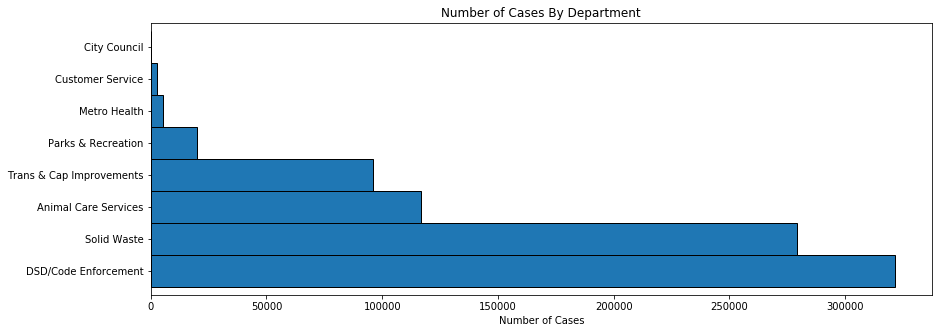

In [4]:
# First aggregate with spark
(
    df.groupBy("department")
    .count()
    # then pass to pandas
    .toPandas()
    .set_index("department")["count"]
    .sort_values(ascending=False)
    .plot.barh(width=1, edgecolor="black", figsize=(14, 5))
)

plt.title("Number of Cases By Department")
plt.ylabel("")
plt.xlabel("Number of Cases")

How long to requests take to get resolved (in days) for each department? 

Text(0.5, 1.0, 'Case Lifetime By Department')

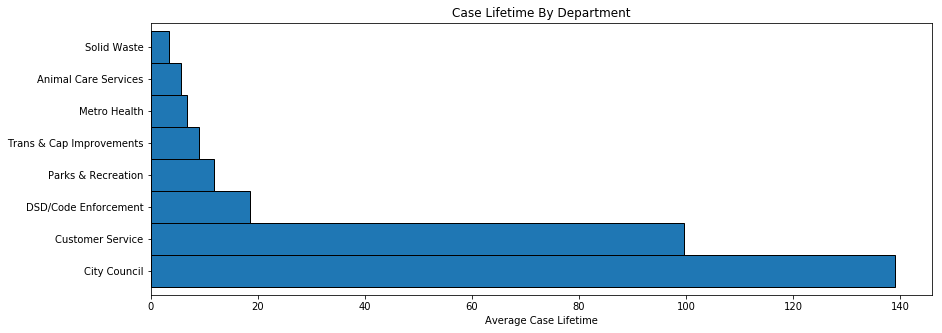

In [5]:
# first aggregate with spark
(
    df.groupBy("department")
    .agg(mean("case_lifetime").alias("avg_case_lifetime"))
    # then pass the data to pandas for visualization
    .toPandas()
    .set_index("department")
    .avg_case_lifetime.sort_values(ascending=False)
    .plot.barh(width=1, edgecolor="black", figsize=(14, 5))
)

plt.xlabel("Average Case Lifetime")
plt.ylabel("")
plt.title("Case Lifetime By Department")

Average case lifetime by department for both open and closed cases:



In [6]:
(
    df.groupBy("department")
    .pivot("case_status")
    .agg(round(mean("case_lifetime"), 2))
    .orderBy("Closed")
    .show(truncate=False)
)

+------------------------+------+------+
|department              |Closed|Open  |
+------------------------+------+------+
|Solid Waste             |3.4   |16.45 |
|Animal Care Services    |5.51  |21.36 |
|Metro Health            |6.82  |4.64  |
|Trans & Cap Improvements|8.0   |54.39 |
|Parks & Recreation      |10.66 |64.72 |
|DSD/Code Enforcement    |15.65 |91.56 |
|City Council            |29.25 |154.07|
|Customer Service        |48.94 |172.94|
+------------------------+------+------+



## Attempt to convert all observations to Pandas dataframe to visualize.

tip: reduce columns! Only the ones to be visualized, and you may find you can convert it, when you wouldn't be able to otherwise. Also by removing columns you aren't going to use in your exploration when working with large amounts of data can make a difference! 

In [7]:
pd_df = df.select("num_days_late",
                  "days_to_closed").toPandas()

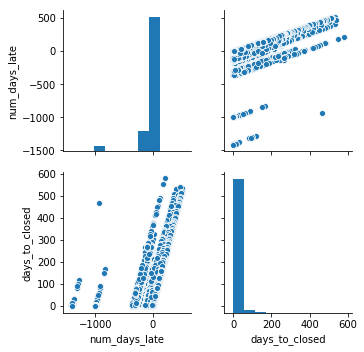

In [8]:
sns.pairplot(pd_df)

## Sample the Spark dataframe to convert to Pandas dataframe and visualize. 

### Simple Random Sample

In [9]:
sample = df.sample(fraction=0.01, seed=13).toPandas()
print("shape:", sample.shape)
sample.head()

shape: (8447, 20)


,case_id,case_opened_date,case_closed_date,case_due_date,case_late,num_days_late,case_closed,service_request_type,SLA_days,case_status,source_id,request_address,council_district,num_weeks_late,zipcode,case_age,days_to_closed,case_lifetime,department,dept_subject_to_SLA
0,1014127348,2018-01-01 07:05:00,2018-01-02 15:33:00,2018-01-17 08:30:00,False,-14.706007,True,Front Or Side Yard Parking,16.058646,Closed,svcCRMSS,"834 BARREL POINT, San Antonio, 78251",004,-2.100858,78251,219.0,1.0,1.0,DSD/Code Enforcement,True
1,1014127499,2018-01-01 13:18:00,2018-02-04 12:16:00,2018-01-06 13:18:00,True,28.957257,True,Animal Neglect,5.000000,Closed,ns16326,"717 ALBERT ST, San Antonio, 78207",001,4.136751,78207,219.0,34.0,34.0,Animal Care Services,True
2,1014127512,2018-01-01 13:45:00,2018-01-09 09:58:00,2018-03-07 08:30:00,False,-56.938229,True,Overgrown Yard/Trash,64.781146,Closed,svcCRMSS,RAINBOW DR and CLOUDHAVEN DR,010,-8.134033,,219.0,8.0,8.0,DSD/Code Enforcement,True
3,1014127595,2018-01-01 15:21:00,2018-01-01 15:56:00,2018-03-28 08:30:00,False,-85.690104,True,Signal Timing Modification,85.714537,Closed,139344,EB IH 10 and MARTIN LUTHER,002,-12.241443,,219.0,0.0,0.0,Trans & Cap Improvements,True
4,1014127618,2018-01-01 15:52:00,2018-01-01 20:08:00,2020-09-26 15:52:00,False,-998.822014,True,Stray Animal,999.000000,Closed,139344,"407 ZARZAMORA N, San Antonio, 78207",005,-142.688859,78207,219.0,0.0,0.0,Animal Care Services,True


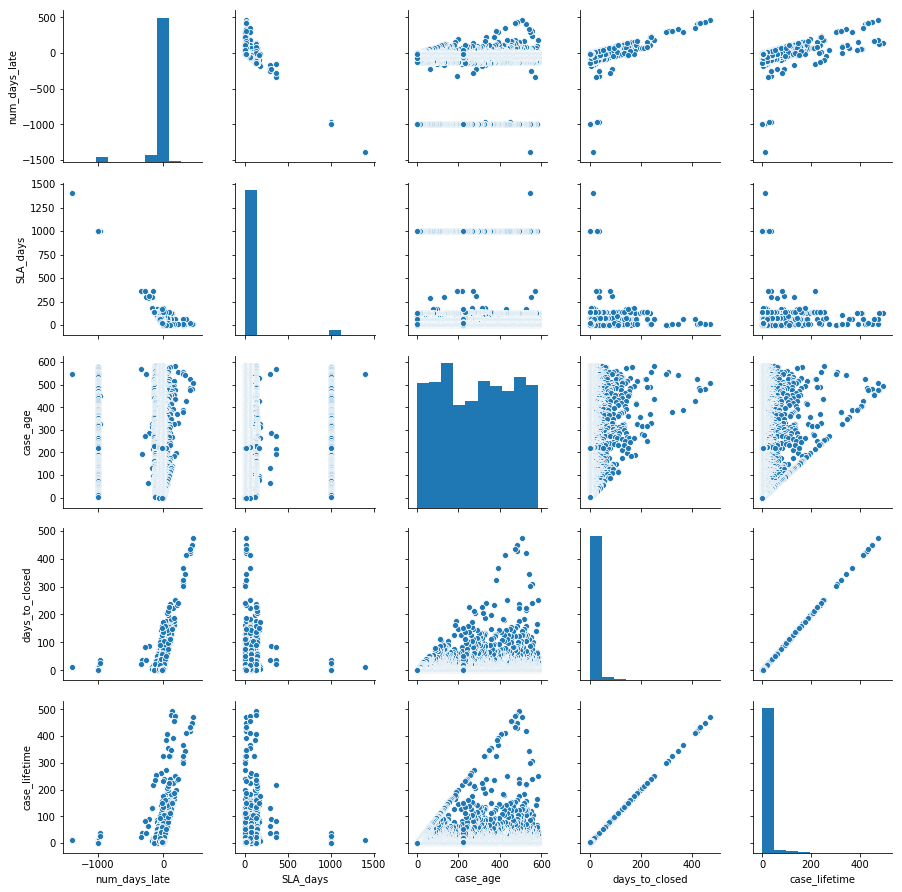

In [10]:
numeric_cols = [
    "num_days_late",
    "SLA_days",
    "case_age",
    "days_to_closed",
    "case_lifetime",
]

sns.pairplot(sample[numeric_cols])

### Stratified Sample

In [19]:
df.groupBy('case_status').count().withColumn('prop', col('count')/df.count()).show()
# let's stratify by case_status

+-----------+------+--------------------+
|case_status| count|                prop|
+-----------+------+--------------------+
|       Open| 18110|0.021515877315540857|
|     Closed|823594|  0.9784841226844592|
+-----------+------+--------------------+



In [25]:
sampled = df.sampleBy("case_status", fractions={'Closed': .05, 'Open': 1.0}, seed=235)

In [26]:
sampled = sampled.toPandas()

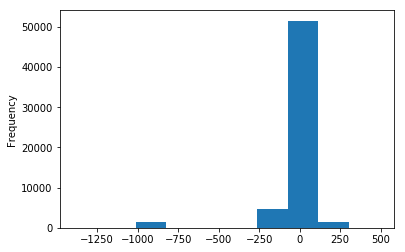

In [27]:
sampled['num_days_late'].plot.hist()

## Sample Spark dataframe before converting to Pandas dataframe to visualize

### Break into smaller dataframes  

Break your data into multiple dataframes with observations together that you would want to compare. E.g. create a dataframe of all open, all closed, all tickets from a certain department, etc.   

In [28]:
df.crosstab('case_status', 'case_late').show()


+---------------------+------+-----+
|case_status_case_late| false| true|
+---------------------+------+-----+
|               Closed|735616|87978|
|                 Open| 11585| 6525|
+---------------------+------+-----+



In [31]:
df.groupBy('council_district').count().show()

+----------------+------+
|council_district| count|
+----------------+------+
|             009| 40916|
|             006| 74095|
|             005|114609|
|             003|102706|
|             008| 42345|
|             001|119309|
|             010| 62926|
|             004| 93778|
|             000|  3830|
|             007| 72445|
|             002|114745|
+----------------+------+



In [32]:
df.groupBy('department').count().show()

+--------------------+------+
|          department| count|
+--------------------+------+
|         Solid Waste|279270|
|Animal Care Services|116915|
|Trans & Cap Impro...| 96193|
|  Parks & Recreation| 19907|
|    Customer Service|  2849|
|        Metro Health|  5163|
|        City Council|    33|
|DSD/Code Enforcement|321374|
+--------------------+------+



In [33]:
parks_rec = df.filter(col('department') == lit('Parks & Recreation')).toPandas()

In [34]:
parks_rec.head()

,case_id,case_opened_date,case_closed_date,case_due_date,case_late,num_days_late,case_closed,service_request_type,SLA_days,case_status,source_id,request_address,council_district,num_weeks_late,zipcode,case_age,days_to_closed,case_lifetime,department,dept_subject_to_SLA
0,1014127888,2018-01-02 07:19:00,2018-01-04 11:47:00,2018-01-05 08:30:00,False,-0.863148,True,Graffiti,3.049120,Closed,svcCRMSS,BORDER BROOK and TIMBERHILL DR,007,-0.123307,,218,2.0,2,Parks & Recreation,True
1,1014127895,2018-01-02 07:23:00,2018-01-17 14:35:00,2018-01-17 08:30:00,True,0.254109,True,Tree Removal,15.046458,Closed,svcCRMSS,"1315 SAN PEDRO AVE, San Antonio, 78212",001,0.036301,78212,218,15.0,15,Parks & Recreation,True
2,1014127914,2018-01-02 07:29:00,2018-01-05 09:41:00,2018-01-11 08:30:00,False,-5.950579,True,Heating and Air Conditioning,9.042049,Closed,svcCRMSS,"5626 SAN FERNANDO, San Antonio, 78237",006,-0.850083,78237,218,3.0,3,Parks & Recreation,True
3,1014127918,2018-01-02 07:30:00,2018-01-11 07:21:00,2018-01-11 08:30:00,False,-0.047731,True,Heating and Air Conditioning,9.041424,Closed,svcCRMSS,"1450 MIRA VISTA, San Antonio, 78228",007,-0.006819,78228,218,9.0,9,Parks & Recreation,True
4,1014128061,2018-01-02 08:22:00,2018-01-02 08:50:00,2018-01-05 08:30:00,False,-2.985741,True,Graffiti,3.005046,Closed,mt13131,"8700 TIMBER PATH, San Antonio, 78250",006,-0.426534,78250,218,0.0,0,Parks & Recreation,True
